In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("data/historical-weather-1940-2022/milano.csv")

# parse time as datetime
data["time"] = pd.to_datetime(data["time"])
data.set_index("time", inplace=True)

# rename columns
data.rename(columns={
  "temperature_2m_max (°C)": "mplt_temp",
  "temperature_2m_min (°C)": "min_temp",
  "temperature_2m_mean (°C)": "mean_temp",
  "precipitation_sum (mm)": "precipitation",
  "rain_sum (mm)": "rain",
  "snowfall_sum (cm)": "snowfall",
  "shortwave_radiation_sum (MJ/m²)": "radiation",
  "et0_fao_evapotranspiration (mm)": "evapotranspiration"
}, inplace=True)

# fix null values
data["precipitation"] = data["precipitation"].replace(np.nan, 0)

# check for null values
# print(data.isnull().sum())

## Temperatura media per ogni anno

Temperatura media per ogni anno, con linea che indica il trend

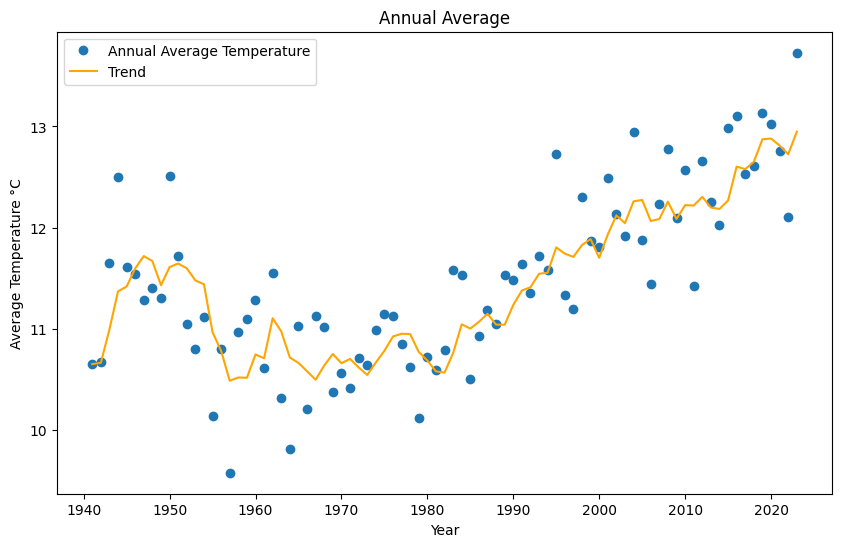

In [77]:
# temperatura media per ogni anno
annual_average = data["mean_temp"].resample("Y").mean()
pd.DataFrame(annual_average)

# trend line
trend_line = annual_average.rolling(window=5, min_periods=1).mean()

# Plot the annual average using dots and the trendline
plt.figure(figsize=(10, 6))
plt.plot(
  annual_average.index,
  annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none"
)
plt.plot(
  trend_line.index,
  trend_line.values,
  color="orange",
  label="Trend"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

## Temperatura media per ogni mese per ogni quarantennio

In [78]:
data["decade"] = data.index.year // 10 * 10

# group by decade and month
decadal_monthly_avg = data.groupby(["decade", data.index.month])["mean_temp"].mean().reset_index()

decadal_monthly_avg

,decade,time,mean_temp
0,1940,1,-1.189644
1,1940,2,1.527915
2,1940,3,7.069355
3,1940,4,12.290667
4,1940,5,15.961935
...,...,...,...
103,2020,8,22.623656
104,2020,9,18.477778
105,2020,10,13.187097
106,2020,11,7.891111


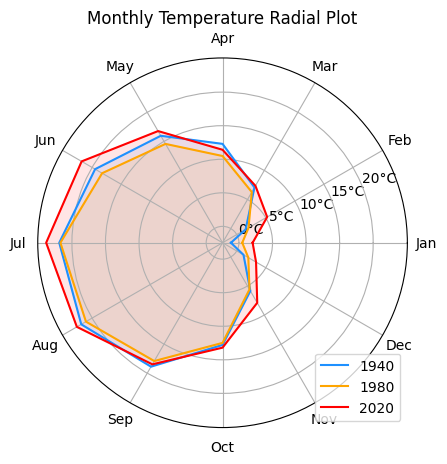

In [79]:
angles = np.deg2rad(np.linspace(0, 360, 12, endpoint=False))
angles = np.append(angles, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})

colors = ["dodgerblue", "orange", "red"]

i = 0
for decade in range(1940, 2021, 40):
  temperatures = decadal_monthly_avg[decadal_monthly_avg["decade"] == decade]
  temperatures_data = temperatures["mean_temp"].to_numpy()
  temperatures_data = np.append(temperatures_data, temperatures_data[0])

  ax.plot(angles, temperatures_data, label=decade, color=colors[i])
  ax.fill(angles, temperatures_data, alpha=0.1, color=colors[i])
  i += 1


ax.set_xticks(angles[:-1])
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

ax.set_yticks(range(0, int(max(temperatures["mean_temp"]) + 1), 5))
ax.set_yticklabels([str(t) + "°C" for t in range(0, int(max(temperatures["mean_temp"]) + 1), 5)])

ax.set_title("Monthly Temperature Radial Plot")
plt.legend(loc="lower right")
plt.show()

#### Differenza (delta) di temperatura relativa alla media tra gli anni 1940-1980

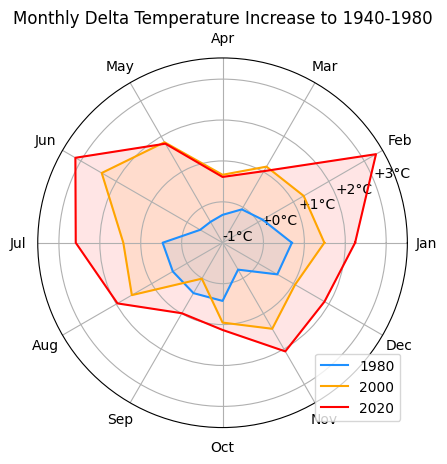

In [80]:
# average temperature for each decade for each month
decadal_40_80 = decadal_monthly_avg[decadal_monthly_avg["decade"].between(1940, 1980, inclusive='both')]

# average temperature for each month of the decade between 1940 and 1980
avg_40_80 = decadal_40_80.groupby("time")["mean_temp"].mean().to_numpy()

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})

colors = ["dodgerblue", "orange", "red"]

i = 0
for decade in range(1980, 2021, 20):
  temperatures = decadal_monthly_avg[decadal_monthly_avg["decade"] == decade]
  temperatures_data = temperatures["mean_temp"].to_numpy()
  
  # calculate delta: ((month i decade avg) - (month 1940-1980 average))
  # t = tuple(month_index, month_temperature), t[0] = index, t[1] = mean_temp
  temperatures_data = list(map(lambda t: t[1] - avg_40_80[t[0]], enumerate(temperatures_data)))

  temperatures_data = np.append(temperatures_data, temperatures_data[0])

  ax.plot(angles, temperatures_data, label=decade, color=colors[i])
  ax.fill(angles, temperatures_data, alpha=0.1, color=colors[i])
  i += 1

ax.set_xticks(angles[:-1])
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

ax.set_yticks(range(-1, 4, 1))
ax.set_yticklabels(["%+d" % (t) + "°C" for t in range(-1, 4, 1)])

ax.set_title("Monthly Delta Temperature Increase to 1940-1980")
plt.legend(loc="lower right")
plt.show()